In [6]:
import pandas as pd

import re, json, glob

from dateutil.parser import parse as date_parse

In [2]:
json_template = "speed_results/iperf_{}_{}mbit.json"
dl_dict = {"DL" : "Download", "UL" : "Upload"}

data = []
for f in glob.glob("speed_results/iperf_?L*json"):
    
    ud    = re.sub(r".*_([UD]L)_.*", r"\1", f)
    ud    = dl_dict[ud]
    speed = float(re.sub(r".*[UD]L_(.*)mbit.json", r"\1", f))
    
    try:
        with open(f) as fo: j = json.load(fo)
    except: continue
        
    mbits_per_s = j["end"]["sum_received"]["bits_per_second"] / 1e6
    
    # print(f, j["end"]["sum_received"]["bits_per_second"] / 1e6)
        
    data.append([ud, speed, mbits_per_s])

    
cols = ["io", "tc_set", "iperf_res"]

df = pd.DataFrame(data, columns = cols)
df = df.pivot(index = "tc_set", values = "iperf_res", columns = "io")

df["DL Ratio"] = df["Download"] / df.index
df["UL Ratio"] = df["Upload"] / df.index

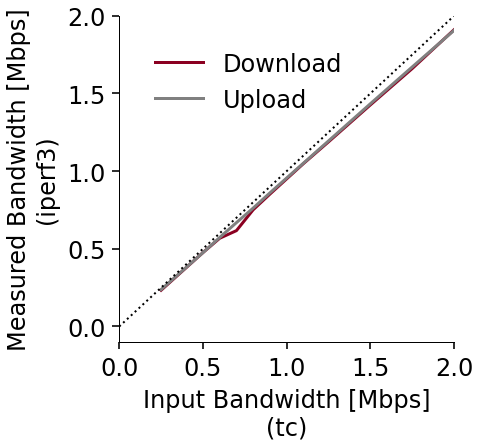

In [3]:
fig, ax = plt.subplots(figsize = (3, 3))

df[["Download", "Upload"]].plot(ax = ax, color = [chred, chgrey])

ax.plot([0, 10], [0, 10], color = "k", lw = 1, ls = ":")

ax.set_xlim(0, 2)
ax.set_ylim(-0.1, 2)

ax.set_xlabel("Input Bandwidth [Mbps]\n(tc)")
ax.set_ylabel("Measured Bandwidth [Mbps]\n(iperf3)")

leg = ax.legend(frameon = False)
fig.savefig("iperf_tc_xy.pdf")

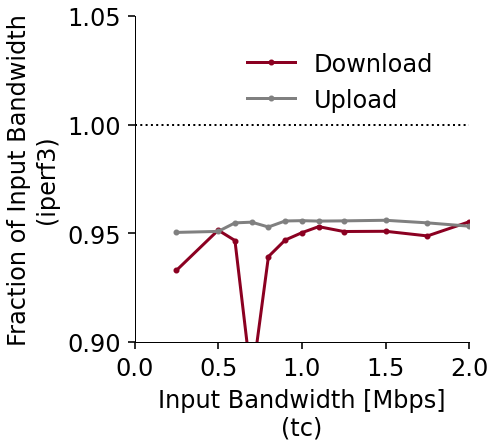

In [4]:
fig, ax = plt.subplots(figsize = (3, 3))

df[["DL Ratio", "UL Ratio"]]\
  .rename(columns = {"DL Ratio" : "Download", "UL Ratio" : "Upload"})\
  .plot(ax = ax, ms = 4, marker = '.', color = [chred, chgrey])

ax.plot([0, 2], [1, 1], c = "k", lw = 1, ls = ":")

ax.set_xlim(0, 2)
ax.set_ylim(0.90, 1.05)

ax.set_xlabel("Input Bandwidth [Mbps]\n(tc)")
ax.set_ylabel("Fraction of Input Bandwidth\n(iperf3)")

leg = ax.legend(frameon = False)
fig.savefig("iperf_tc_ratio.pdf")

### Zoom Metrics

In [109]:
def get_meeting_qos(meeting_file):
    
    with open(meeting_file) as f:
        j = json.load(f)
        
    qos_values = []

    qos = j["user_qos"]

    for m in qos:
        
        if not m["video_output"]["bitrate"]: continue 

        ts      = int(date_parse(m["date_time"]).timestamp())

        dl_bitrate = m["video_input"]["bitrate"].replace(" kbps", "")
        dl_loss    = m["video_input"]["avg_loss"].replace("%", "")
        dl_latency = m["video_input"]["latency"].replace(" ms", "")
        dl_fps     = m["video_input"]["frame_rate"].replace(" fps", "")

        dl_res     = m["video_input"]["resolution"]
        dl_resx, dl_resy = [int(v) for v in dl_res.split("*")]

        ul_bitrate = int(m["video_output"]["bitrate"].replace(" kbps", "")) / 1000
        ul_loss    = float(m["video_output"]["avg_loss"].replace("%", ""))
        ul_latency = float(m["video_output"]["latency"].replace(" ms", ""))
        ul_fps     = int(m["video_output"]["frame_rate"].replace(" fps", ""))
        ul_res     = m["video_output"]["resolution"]
        ul_resx, ul_resy = [int(v) for v in ul_res.split("*")]

        dl_bitrate = float(dl_bitrate) / 1000. if dl_bitrate else np.nan
        ul_latency = float(ul_latency) if ul_latency else np.nan
        dl_latency = float(dl_latency) if dl_latency else np.nan
        dl_loss    = float(dl_loss) if dl_loss else np.nan
        dl_fps     = float(dl_fps)  if dl_fps  else np.nan

        qos_values.append([ts, 
                           dl_bitrate, dl_loss, dl_latency, dl_resx, dl_resy, dl_fps, 
                           ul_bitrate, ul_loss, ul_latency, ul_resx, ul_resy, ul_fps 
                          ])


    columns = ["ts", "dl_bitrate", "dl_loss", "dl_latency", "dl_resx", "dl_resy", "dl_fps", 
                     "ul_bitrate", "ul_loss", "ul_latency", "ul_resx", "ul_resy", "ul_fps"]
    df = pd.DataFrame(qos_values, columns = columns)

    # df.ts = pd.to_datetime(df.ts, unit = "s")
    # df.set_index("ts", inplace = True)
    
    df.sort_values(by = "ts")
    
    return df


colors = {"ul" : chred, "dl": "0.6"}

label = {"latency" : "Latency", "loss" : "Loss", "ul" : "Upload", "dl" : "Download"}
for d in ["ul", "dl"]:
    for k, v in {"bitrate" : "Bitrate [Mpbs]", "loss" : "Loss [%]", 
                 "latency" : "Latency [ms]", "fps" : "FPS", 
                 "resx" : "Horizontal\nResolution"}.items():
        label[d + "_" + k] = v
         

    
def plot_bw(qos_bw):
    
    fig, axes = plt.subplots(5, 1, figsize = (6, 9), sharex = True)
    
    for d in ["dl", "ul"]:
        
        qos_dir = qos_bw.query(f"{d} <= 10").groupby(d).mean()

        label = {"ul" : "Upload", "dl" : "Download",
                 d + "_bitrate" : "Bitrate [Mpbs]", 
                 d + "_loss" : "Loss [%]", 
                 d + "_latency" : "Latency [ms]", 
                 d + "_fps" : "FPS", d + "_resx" : "Horizontal\nResolution"}


        for y, ax in zip(["bitrate", "loss", "latency", "fps", "resx"], axes):

            y = d + "_" + y
            
            qos_dir[y].plot(ax = ax, color = colors[d], style = ".-",
                            label = label[d])
            ax.set_ylabel(label[y], labelpad = 10)
            ax.set_xlabel("Bandwidth [Mbps]")
            
            if "fps" in y: ax.legend()

        ax_ylim = axes[0].get_ylim()
        axes[0].plot([0, 2], [0, 2], color = "k", ls = ":", lw = 0.5)
        axes[0].set_ylim(0, 3)

    fig.savefig(f"zoom_perf_bw.pdf")
    fig.savefig(f"zoom_perf_bw.png", transparent = False)

    
ylim = {"ul_bitrate" : (2, 4), "dl_bitrate" : (2, 4), 
        "ul_loss" : (0, 20), "dl_loss" : (0, 20), 
        "ul_latency" : (0, 100), "dl_latency" : (0, 100), 
        "ul_fps" : (18, 24), "dl_fps" : (18, 24), 
        "dl_resx" : (500, 1500), "ul_resx" : (500, 1500), }
    
def plot_ll(qos_ll):
    
    fig, axes = plt.subplots(5, 2, figsize = (8, 9))
    
    for vi, v in enumerate(["latency", "loss"]):
        
        qos_v = qos_ll.query(f"{v} != 0").groupby(v).mean()

        for d in ["ul", "dl"]:

            for yi, y in enumerate(["bitrate", "loss", "latency", "fps", "resx"]):

                y = d + "_" + y

                qos_v[y].plot(ax = axes[yi][vi], color = colors[d], style = ".-",
                              label = label[d])
                axes[yi][0].set_ylabel(label[y], labelpad = 10)
                axes[yi][vi].set_xlabel(label[v])

                if "fps" in y and v == "loss": axes[yi][vi].legend(loc = "lower right")

                axes[yi][vi].set_ylim(ylim[y])

        
    plt.subplots_adjust(wspace = 0.3)
        
    fig.savefig(f"zoom_perf_ll.pdf")
    fig.savefig(f"zoom_perf_ll.png", transparent = False)

     



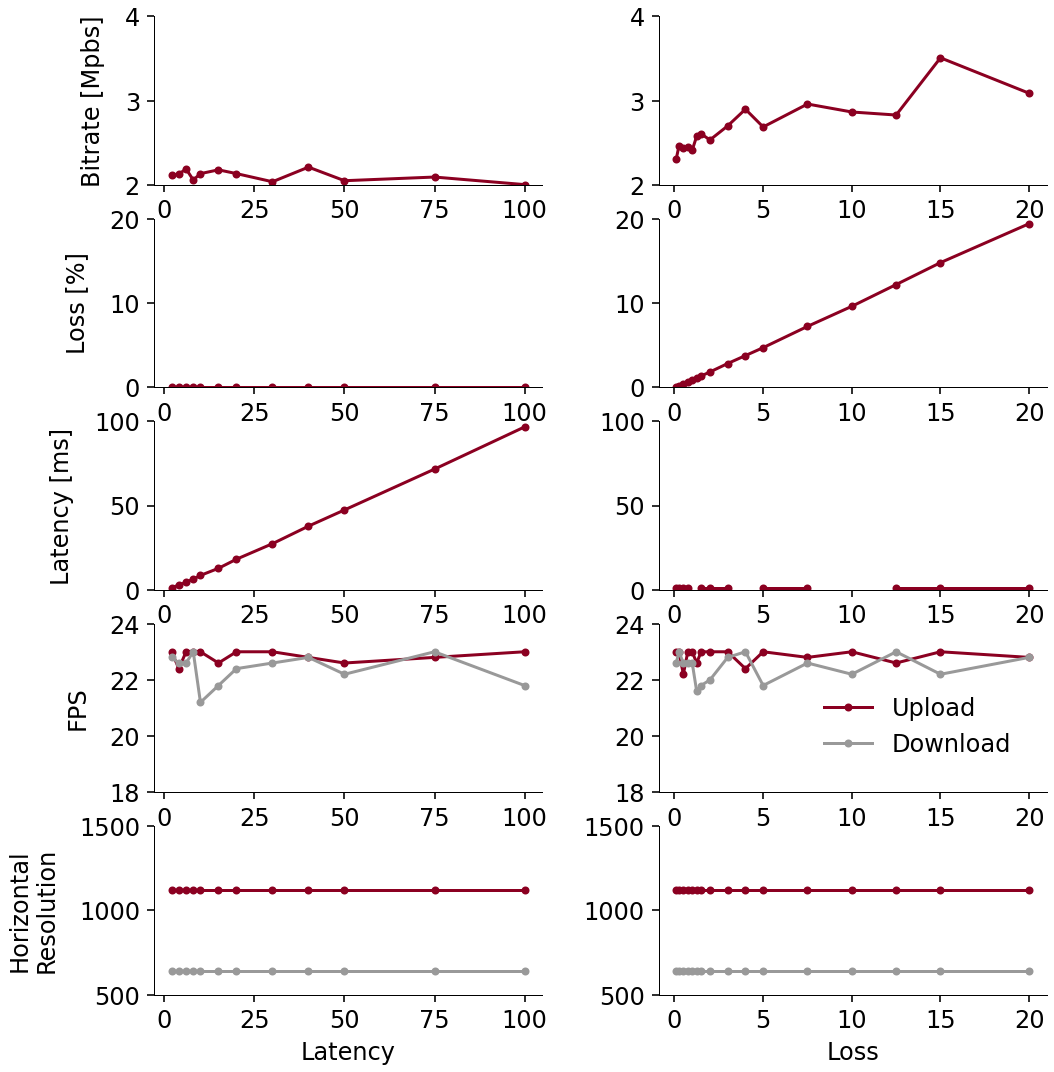

In [110]:
ll = pd.read_csv("tarun/latency_loss.out", sep = " ", 
                 names = ["ts", "duration", "dl", "ul", "latency", "loss"])
ll.sort_values("ts", inplace = True)

qos = get_meeting_qos("ll_meeting_metrics.json")

qos_ll = pd.merge_asof(qos, ll, tolerance = 300)
qos_ll.query("~dl.isnull()", engine='python', inplace = True)

plot_ll(qos_ll)

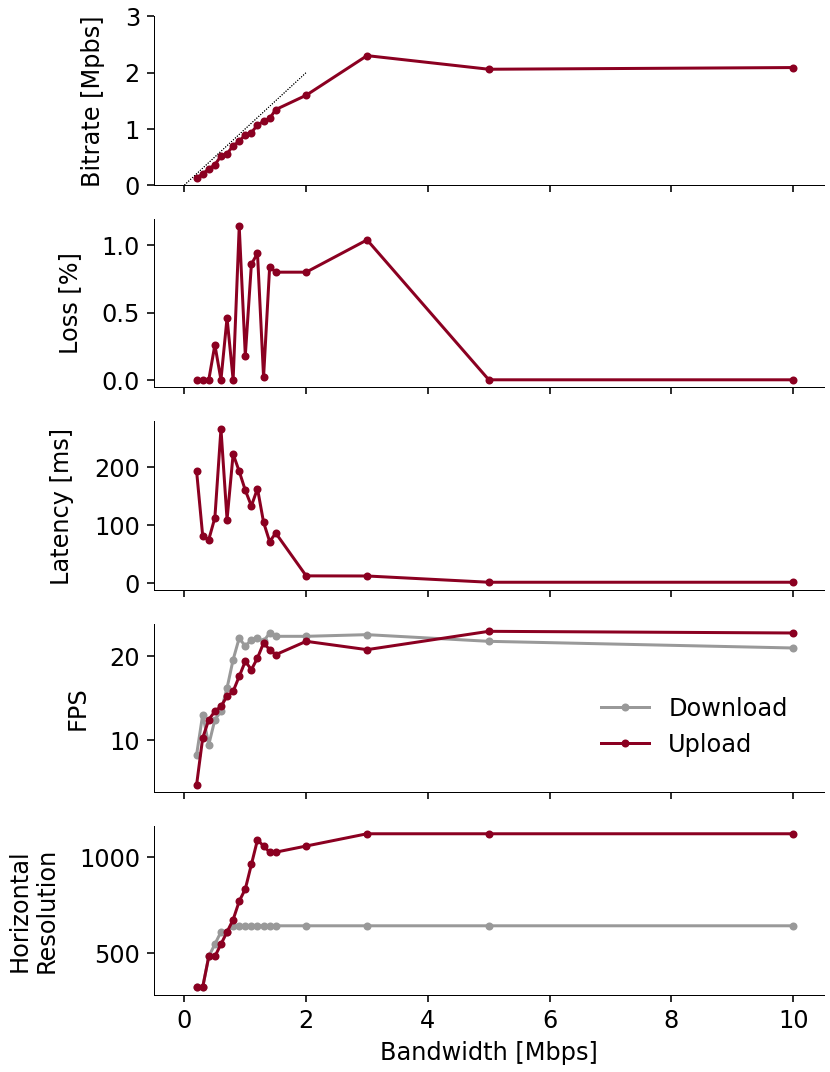

In [111]:
bw = pd.read_csv("tarun/bandwidth.out", sep = " ", names = ["ts", "duration", "dl", "ul", "latency", "loss"])
bw.sort_values("ts", inplace = True)

qos = get_meeting_qos("bw_meeting_metrics.json")

qos_bw = pd.merge_asof(qos, bw, tolerance = 300)
qos_bw.query("~dl.isnull()", engine='python', inplace = True)

plot_bw(qos_bw)